The first attempt used work from <a href = https://www.kaggle.com/code/dgawlik/house-prices-eda title = 'first attempt'> this kaggle work </a>, *however* it was almost impossible to use, since the core regression does not make a lot of sense for me.

And thus, I decided to change my approach and find another kaggle work to follow

<div class="alert alert-block alert-warning">
<b>Warning:</b> Even though I stopped using my previous notebook, it was an incredibly useful. Since I kind of learnt how to use seaborn, namely FacetGrid. I tried to understand ANOVA test and shapiro wilk test, what is a p-value and how to use it and calculate
</div>

I hope at the end of this notebook I will grasp the understading of regression, and I finally predict the SalePrice.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy import stats 
from scipy.stats import norm, skew  
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

qualitative = [x for x in train.columns if train[x].dtype == 'object']
quantitative = [x for x in train.columns if train[x].dtype != 'object']

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
train.shape

(1460, 81)

In [5]:
#drop Id column from both train and test dataset
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

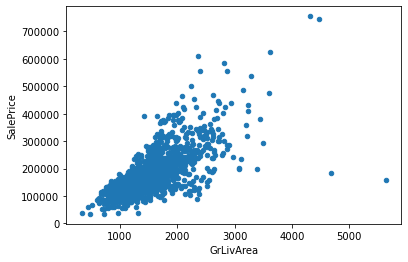

In [6]:
# Again, in the kaggle notebook that I am currently working with theare are no explanation why the decided to check, and why
# they think that 'GrLivArea' has some outliners, and why other do not have it.
# the only think was mentioned that it was bad to blindly delete all of the outliners...
train[['SalePrice', 'GrLivArea']].plot.scatter(x = 'GrLivArea', y = 'SalePrice')

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

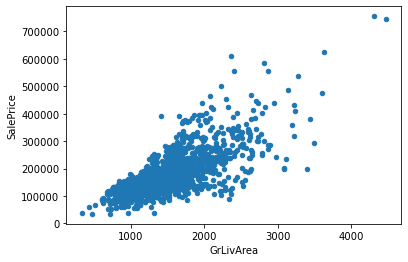

In [7]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] <300000)].index)
train[['SalePrice', 'GrLivArea']].plot.scatter(x = 'GrLivArea', y = 'SalePrice')

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

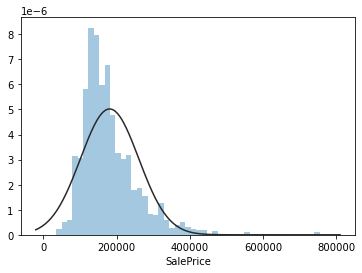

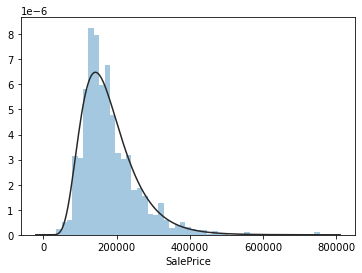

<Figure size 432x288 with 0 Axes>

In [8]:
# Again, in the next step we decided to make SalePrice to be more normaly distributed, but it is not necessary. There is no
# explanation
x = train['SalePrice']
plt.figure(1)
sns.distplot(x, fit= stats.norm, kde=False)
plt.figure(2)
sns.distplot(x, fit = stats.lognorm, kde=False)
plt.figure(3)

https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p/49538384#49538384

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

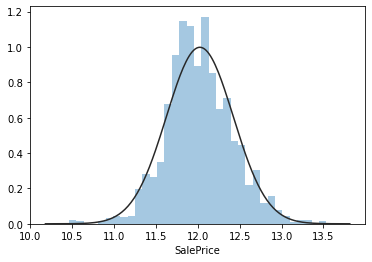

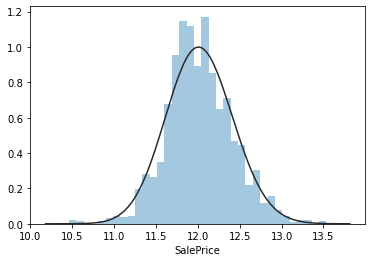

<Figure size 432x288 with 0 Axes>

In [9]:
# here decided to log-transform SalePrice
# besides in the kaggle they used log1p - it does not make sense since 'SalePrice' are not small values.
x = np.log(train['SalePrice'])
plt.figure(1)
sns.distplot(x, fit= stats.norm, kde=False)
plt.figure(2)
sns.distplot(x, fit = stats.lognorm, kde=False)
plt.figure(3)

In [10]:
# as i said it does not make sense to use log1p, however later on we will use boxcox1p to transform skewed data
train['SalePrice'] = np.log1p(train['SalePrice'])

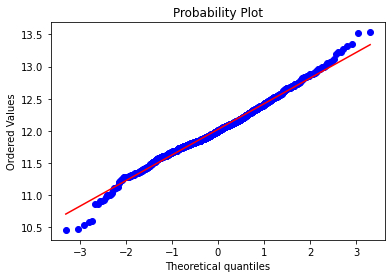

In [11]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [12]:
df = pd.concat((train, test))
df.drop(['SalePrice'], inplace = True, axis = 'columns')
print('grouped together size of a new data without "SalePrice": {}'.format(df.shape))

grouped together size of a new data without "SalePrice": (2917, 79)


<AxesSubplot:>

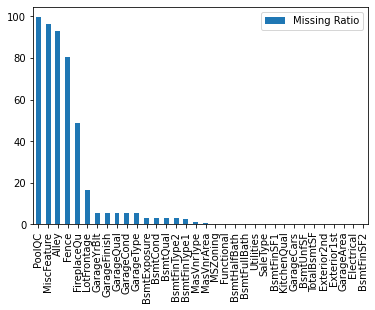

In [13]:
data_NA = pd.DataFrame()
data_NA['Values'] = df.isnull().sum().sort_values(ascending = False)
data_NA['Values'] = data_NA[data_NA > 0]
data_NA['Missing Ratio'] = data_NA['Values'] * 100 / len(df)
data_NA.dropna(inplace = True)
data_NA.plot.bar(y = 'Missing Ratio')

Text(0.5, 1.0, 'Percent missing data by feature')

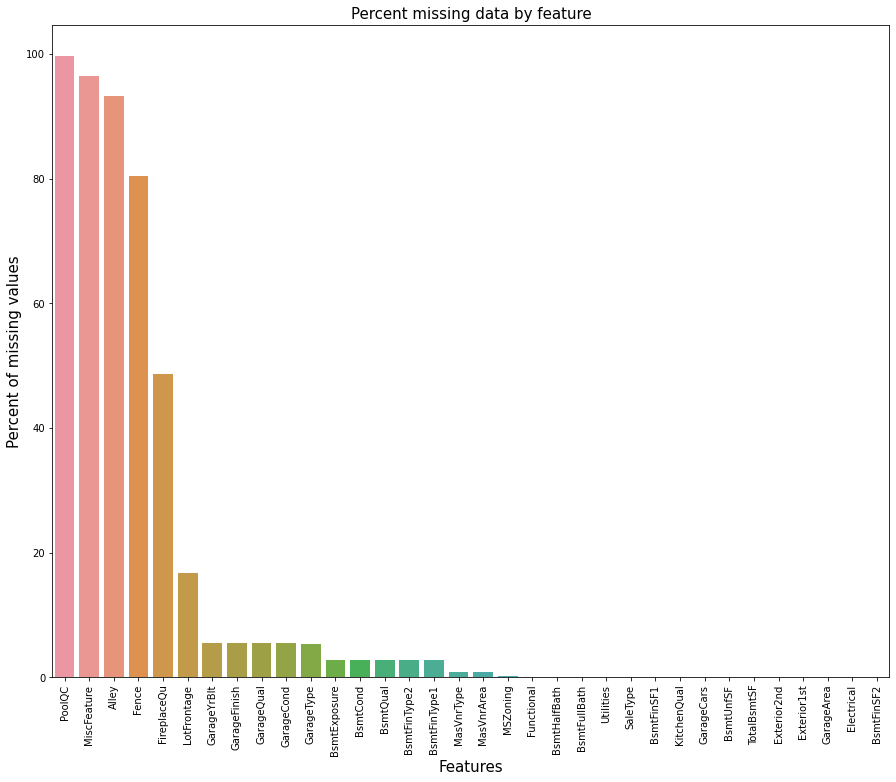

In [14]:
plt.subplots(figsize = (15, 12))
plt.xticks(rotation = 90)
sns.barplot(x = data_NA.index , y = data_NA['Missing Ratio'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Handling missing values
1. PoolQC<br>
data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
2. MiscFeature<br>
data description says NA means "no misc feature"
3. Alley<br>
data description says NA means "no alley access"
4. Fence<br>
data description says NA means "no fence"
5. FireplaceQu<br>
data description says NA means "no fireplace"
6. LotFrontage<br>
Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
7. GarageType, GarageFinish, GarageQual and GarageCond<br>
Replacing missing data with None
8. GarageYrBlt, GarageArea and GarageCars<br>
Replacing missing data with 0 (Since No garage = no cars in such garage.)
9. BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath<br>
missing values are likely zero for having no basement
10. BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2<br>
For all these categorical basement-related features, NaN means that there is no basement.
12. MSZoning (The general zoning classification)<br>
'RL' is by far the most common value. So we can fill in missing values with 'RL'
13. Utilities<br>
For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
14. Functional<br>
data description says NA means typical
15. Electrical<br>
It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
16. KitchenQual<br>
Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
17. Exterior1st and Exterior2nd<br>
Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
18. SaleType<br>
Fill in again with most frequent which is "WD"
19. MSSubClass<br>
Na most likely means No building class. We can replace missing values with None

In [15]:
df["PoolQC"] = df["PoolQC"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")
df["Alley"] = df["Alley"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())

garage_qualitative = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_quantitative = ['GarageYrBlt', 'GarageArea' , 'GarageCars']
bsmt_qualitative = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
bsmt_quantitative = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

def function_qualitative(data, list):
    for col in list:
        data[col] = data[col].fillna('None')

def function_quantitative(data, list):
    for col in list:
        data[col] = data[col].fillna(0)


function_qualitative(df, garage_qualitative)
function_qualitative(df, bsmt_qualitative)
function_quantitative(df, garage_quantitative)
function_quantitative(df, bsmt_quantitative)


df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

df = df.drop(['Utilities'], axis = 1)

df["Functional"] = df["Functional"].fillna("Typ")

df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

df['MSSubClass'] = df['MSSubClass'].fillna("None")


In [16]:
df.columns[df.isnull().any()]

Index(['MasVnrType', 'MasVnrArea'], dtype='object')

In [17]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

In [18]:
#some numerical variabels are in fact categorical
df['MSSubClass'] = df['MSSubClass'].map(str)
df['OverallCond'] = df['OverallCond'].map(str)
df['YrSold'] = df['YrSold'].map(str)
df['MoSold'] = df['MoSold'].map(str)


https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

In [19]:
# example of label encoder
dff = pd.DataFrame(data = list(df['FireplaceQu']), columns = ['FireplaceQu_num'])
lbl = LabelEncoder()
dff['FireplaceQu_cat'] = lbl.fit_transform(dff['FireplaceQu_num'])
dff.head(5)

FireplaceQu_num  FireplaceQu_cat
0            None                3
1              TA                5
2              TA                5
3              Gd                2
4              TA                5

In [20]:
# Label Encoding some categorical variables that may contain information in their ordering set
from sklearn.preprocessing import LabelEncoder
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
labelencoder = LabelEncoder()

df[cols] = df[cols].apply(lambda x: labelencoder.fit_transform(x))

print('Shape all_data: {}'.format(df.shape))

Shape all_data: (2917, 78)


Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution
https://www.investopedia.com/terms/s/skewness.asp#:~:text=Skewness%20refers%20to%20a%20distortion,is%20said%20to%20be%20skewed.
https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de#:~:text=skewness()%20function%20in%20pandas,present%20in%20the%20DataFrame%20object.

In [21]:
#example how to calculate skewnes
dff = df.copy
df['MSSubClass'].skew()

0.1397809153036591

In [22]:
numeric = df.dtypes[df.dtypes != 'object'].index
skewness = df[numeric].apply(lambda x: x.skew())
skewness = pd.DataFrame({'Skew': skewness}).sort_values(by = ['Skew'], ascending = False)
skewness

Skew
MiscVal        21.950962
PoolArea       17.697766
LotArea        13.116240
LowQualFinSF   12.090757
3SsnPorch      11.377932
LandSlope       4.975813
KitchenAbvGr    4.302763
BsmtFinSF2      4.146636
EnclosedPorch   4.004404
ScreenPorch     3.947131
BsmtHalfBath    3.932018
MasVnrArea      2.623068
OpenPorchSF     2.530660
WoodDeckSF      1.845741
1stFlrSF        1.257933
LotFrontage     1.228937
GrLivArea       1.069300
BsmtFinSF1      0.981149
BsmtUnfSF       0.920161
2ndFlrSF        0.861999
TotRmsAbvGrd    0.749618
Fireplaces      0.725651
HalfBath        0.697024
TotalBsmtSF     0.672097
BsmtFullBath    0.622735
OverallCond     0.569607
HeatingQC       0.485784
FireplaceQu     0.332782
BedroomAbvGr    0.326736
GarageArea      0.216968
OverallQual     0.189688
FullBath        0.165599
MSSubClass      0.139781
YrSold          0.132064
BsmtFinType1    0.083684
GarageCars     -0.219410
YearRemodAdd   -0.450365
BsmtQual       -0.488614
YearBuilt      -0.599503
GarageFinish   -0.610267
LotShape       -0.618882
MoSold         -0.646506
Alley          -0.652041
BsmtExposure   -1.117896
KitchenQual    -1.450560
ExterQual      -1.800989
Fence          -1.993675
ExterCond      -2.497774
BsmtCond       -2.862744
PavedDrive     -2.979273
BsmtFinType2   -3.044545
GarageQual     -3.074369
CentralAir     -3.459334
GarageCond     -3.596139
GarageYrBlt    -3.906642
Functional     -4.056212
Street        -15.502729
PoolQC        -21.228518

In [23]:
# to be honest, I understand absolutely nothing here, especially regarding box cox transformation
skewness.Skew = abs(skewness.Skew)
skewness = skewness[skewness > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
lam = 0.15
for feature in skewness.index:
    df[feature] = boxcox1p(df[feature], lam)

There are 35 skewed numerical features to Box Cox transform


In [30]:
#then we converted categorical features into dummies. It does not make sense, why now we use dummies, whereas in the past
# we used LabelEncoder??
df = pd.get_dummies(df)
df.head(10)

MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  LandSlope  \
0          10     5.831328  19.212182  0.730463      1         3        0.0   
1           5     6.221214  19.712205  0.730463      1         3        0.0   
2          10     5.914940  20.347241  0.730463      1         0        0.0   
3          11     5.684507  19.691553  0.730463      1         0        0.0   
4          10     6.314735  21.325160  0.730463      1         0        0.0   
5           9     6.337529  21.282283  0.730463      1         0        0.0   
6           5     6.098626  19.907529  0.730463      1         3        0.0   
7          10     5.946998  20.023862  0.730463      1         0        0.0   
8           9     5.392276  17.989871  0.730463      1         3        0.0   
9           4     5.357203  18.712544  0.730463      1         3        0.0   

   OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0            7            4       2003  ...               0             0   
1            6            7       1976  ...               0             0   
2            7            4       2001  ...               0             0   
3            7            4       1915  ...               0             0   
4            8            4       2000  ...               0             0   
5            5            4       1993  ...               0             0   
6            8            4       2004  ...               0             0   
7            7            5       1973  ...               0             0   
8            7            4       1931  ...               0             0   
9            5            5       1939  ...               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   
5             0            1                      0                      0   
6             0            1                      0                      0   
7             0            1                      0                      0   
8             0            1                      1                      0   
9             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   
5                     0                     0                     1   
6                     0                     0                     1   
7                     0                     0                     1   
8                     0                     0                     0   
9                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
5                      0  
6                      0  
7                      0  
8                      0  
9                      0  

[10 rows x 219 columns]

In [31]:
df.shape

(2917, 219)

In [38]:
# Since we concantenated train and test, we can devide them once again
ntrain = train.shape[0]
train = df[:ntrain]
test = df[ntrain:] 

## The most interesting and most difficult part - Modeling

In [47]:
# For now I have no idea what all of these 
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Here are some of the conclusions so far:
1. I do understand data cleaning, prepoartion, some of the basic statistic
2. It is not too difficult to understand shapiro wiki, ANOVA test - since they are pretty intuitive and tbh easy to understand
3. However, I am not ready for the modeling, not at all. I tried to understand the code from Kaggle, but it was absolutely impossible since I have no idea what it is all about.


# What we are going to do
1. I would futher straingth my data analytic skills, but also I really want to finish this competiotion.
2. I need to read some books about ML and Data Scinece, since the modeling is all about it 
3. After I feel ready (at least read 1 book) - I will come back to finish this notebook 